### **Introduction**

Restructure a flattened and/or denormalized dataset so it can be loaded into a SQL or Graph database. Identify and demonstrate a form of analysis that is made easier by restructuring the data.

### **Dataset**

Yelp Dataset - https://www.kaggle.com/yelp-dataset/yelp-dataset

### **Importing Necessary Libraries**

In [1]:
#Importing necessary libraries
import json
import pandas as pd
import matplotlib.pyplot as plt

### **Data Loading**

In [2]:
# Load the Yelp dataset from JSON files into Python DataFrames
business_data = pd.read_json('business.json', lines=True)
business_data = pd.concat([pd.DataFrame(json.loads(line), index=[0]) for line in open('business.json')])

In [3]:
# Display the first few rows to understand the structure
print(business_data.head())

              business_id                      name  \
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
0  mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
0  tUFrWirKiKi_TAnsVWINQQ                    Target   
0  MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
0  mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   

                           address           city state postal_code  \
0           1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
0  87 Grasso Plaza Shopping Center         Affton    MO       63123   
0             5255 E Broadway Blvd         Tucson    AZ       85711   
0                      935 Race St   Philadelphia    PA       19107   
0                    101 Walnut St     Green Lane    PA       18054   

    latitude   longitude  stars  review_count  is_open attributes  \
0  34.426679 -119.711197    5.0             7        0        NaN   
0  38.551126  -90.335695    3.0            15        1        NaN   
0  32.223236 -110.880452    3.5    

In [4]:
# Save the dataframe as a CSV file
business_data.to_csv('business.csv', index=False)

In [5]:
# Print the number of records loaded from each file
print(f"Number of business records: {len(business_data)}")

Number of business records: 150346


### **Reading the CSV File**

In [6]:
# Read the CSV file back into a pandas dataframe
business_df = pd.read_csv('business.csv')

### **Restructuring the Data**

In [7]:
# Read the business.csv file
business_df = pd.read_csv('business.csv')

# Display the first few rows to verify the structure
print(business_df.head())

# Check if each column contains atomic values
for column in business_df.columns:
    is_multi_valued = business_df[column].apply(lambda x: isinstance(x, str) and ',' in x).any()
    if is_multi_valued:
        print(f"The column '{column}' contains multi-valued attributes.")
    else:
        print(f"The column '{column}' contains atomic values.")



              business_id                      name  \
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1  mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
2  tUFrWirKiKi_TAnsVWINQQ                    Target   
3  MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
4  mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   

                           address           city state postal_code  \
0           1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
1  87 Grasso Plaza Shopping Center         Affton    MO       63123   
2             5255 E Broadway Blvd         Tucson    AZ       85711   
3                      935 Race St   Philadelphia    PA       19107   
4                    101 Walnut St     Green Lane    PA       18054   

    latitude   longitude  stars  review_count  is_open  attributes  \
0  34.426679 -119.711197    5.0             7        0         NaN   
1  38.551126  -90.335695    3.0            15        1         NaN   
2  32.223236 -110.880452    3.5 

In [8]:
import pandas as pd

# Load the denormalized dataset
business_df = pd.read_csv('business.csv')

# Separate address information into a separate table
address_df = business_df[['business_id', 'address', 'city', 'state', 'postal_code']].drop_duplicates().reset_index(drop=True)

# Separate category information into a separate table
categories_df = business_df[['business_id', 'categories']].explode('categories').dropna().reset_index(drop=True)

# Create a mapping table for many-to-many relationship between businesses and categories
business_category_df = business_df[['business_id', 'categories']].explode('categories').dropna().reset_index(drop=True)

# Extract and format reviews data (assuming a single 'stars' column)
reviews_df = business_df[['business_id', 'stars']].dropna().reset_index(drop=True)

# Save the normalized tables to CSV files
address_df.to_csv('address.csv', index=False)
categories_df.to_csv('categories.csv', index=False)
business_category_df.to_csv('business_category.csv', index=False)
reviews_df.to_csv('reviews.csv', index=False)

### **Loading the Normalized Data into the SQL Database**

In [9]:
import sqlite3
import pandas as pd

# Connect to SQLite database
conn = sqlite3.connect('yelp_business_data.db')

# Function to execute SQL query
def execute_query(query):
    cursor = conn.cursor()
    cursor.execute(query)
    conn.commit()

# Load the normalized datasets
address_df = pd.read_csv('address.csv')
categories_df = pd.read_csv('categories.csv')
business_category_df = pd.read_csv('business_category.csv')

# Create tables
create_address_table_query = '''
CREATE TABLE IF NOT EXISTS Address (
    business_id VARCHAR(100) PRIMARY KEY,
    address VARCHAR(100),
    city VARCHAR(100),
    state VARCHAR(100),
    postal_code VARCHAR(100)
);
'''

create_categories_table_query = '''
CREATE TABLE IF NOT EXISTS Categories (
    category_id int PRIMARY KEY,
    categories VARCHAR(100)
);
'''

create_businesscategory_table_query = '''
CREATE TABLE IF NOT EXISTS BusinessCategory (
    business_id VARCHAR(100),
    category_id INTEGER,
    FOREIGN KEY(business_id) REFERENCES Address(business_id),
    FOREIGN KEY(category_id) REFERENCES Categories(category_id)
);
'''

# Execute SQL statements to create tables
execute_query(create_address_table_query)
execute_query(create_categories_table_query)
execute_query(create_businesscategory_table_query)

# Commit changes and close connection
conn.commit()
conn.close()

In [10]:
import sqlite3
import pandas as pd

# Connect to SQLite database
conn = sqlite3.connect('yelp_business_data.db')

# Function to execute SQL query
def execute_query(query):
  cursor = conn.cursor()
  cursor.execute(query)
  conn.commit()

# Load the normalized datasets
address_df = pd.read_csv('address.csv')
categories_df = pd.read_csv('categories.csv')
business_category_df = pd.read_csv('business_category.csv')
reviews_df = pd.read_csv('reviews.csv')

# Create tables
create_address_table_query = '''
CREATE TABLE IF NOT EXISTS Address (
  business_id VARCHAR(100) PRIMARY KEY,
  address VARCHAR(100),
  city VARCHAR(100),
  state VARCHAR(100),
  postal_code VARCHAR(100)
);
'''

create_categories_table_query = '''
CREATE TABLE IF NOT EXISTS Categories (
  category_id int PRIMARY KEY,
  categories VARCHAR(100)
);
'''

create_businesscategory_table_query = '''
CREATE TABLE IF NOT EXISTS BusinessCategory (
  business_id VARCHAR(100),
  category_id INTEGER,
  FOREIGN KEY(business_id) REFERENCES Address(business_id),
  FOREIGN KEY(category_id) REFERENCES Categories(category_id)
);
'''

create_reviews_table_query = '''
CREATE TABLE IF NOT EXISTS Reviews (
  business_id VARCHAR(100),
  stars INT,
  FOREIGN KEY(business_id) REFERENCES Address(business_id)
);
'''

# Execute SQL statements to create tables
execute_query(create_address_table_query)
execute_query(create_categories_table_query)
execute_query(create_businesscategory_table_query)
execute_query(create_reviews_table_query)

# Commit changes and close connection
conn.commit()
conn.close()


In [11]:
# Connect to SQLite database
conn = sqlite3.connect('yelp_business_data.db')

# Function to execute SQL query and return results
def execute_query(query):
    cursor = conn.cursor()
    cursor.execute(query)
    rows = cursor.fetchall()
    for row in rows:
        print(row)

# Query to retrieve table schema
query = """
SELECT name, sql
FROM sqlite_master
WHERE type='table';
"""

# Print table schema
print("Database Schema:")
execute_query(query)

# Close connection
conn.close()


Database Schema:
('Address', 'CREATE TABLE Address (\n    business_id VARCHAR(100) PRIMARY KEY,\n    address VARCHAR(100),\n    city VARCHAR(100),\n    state VARCHAR(100),\n    postal_code VARCHAR(100)\n)')
('Categories', 'CREATE TABLE Categories (\n    category_id int PRIMARY KEY,\n    categories VARCHAR(100)\n)')
('BusinessCategory', 'CREATE TABLE BusinessCategory (\n    business_id VARCHAR(100),\n    category_id INTEGER,\n    FOREIGN KEY(business_id) REFERENCES Address(business_id),\n    FOREIGN KEY(category_id) REFERENCES Categories(category_id)\n)')
('Reviews', 'CREATE TABLE Reviews (\n  business_id VARCHAR(100),\n  stars INT,\n  FOREIGN KEY(business_id) REFERENCES Address(business_id)\n)')


In [12]:
import sqlite3
import pandas as pd

# Connect to SQLite database
conn = sqlite3.connect('yelp_business_data.db')
cursor = conn.cursor()

# Read CSV files into pandas dataframes
address_df = pd.read_csv('address.csv')
categories_df = pd.read_csv('categories.csv')
business_category_df = pd.read_csv('business_category.csv')
reviews_df = pd.read_csv('reviews.csv')  # Include reviews data

# Insert data into Address table
address_df.to_sql('Address', conn, if_exists='replace', index=False)

# Insert data into Categories table
categories_df.to_sql('Categories', conn, if_exists='replace', index=False)

# Insert data into BusinessCategory table
business_category_df.to_sql('BusinessCategory', conn, if_exists='replace', index=False)

# Insert data into Reviews table (assuming 'reviews.csv' has business_id and stars)
reviews_df.to_sql('Reviews', conn, if_exists='replace', index=False)

# Commit changes and close connection
conn.commit()
conn.close()

print("Data inserted successfully.")


Data inserted successfully.


In [13]:
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect('yelp_business_data.db')
cursor = conn.cursor()

# Print Address table
print("Address Table:")
cursor.execute("SELECT * FROM Address LIMIT 10")
rows = cursor.fetchall()
for row in rows:
  print(row)
print("\n")

# Print Categories table
print("Categories Table:")
cursor.execute("SELECT * FROM Categories LIMIT 10")
rows = cursor.fetchall()
for row in rows:
  print(row)
print("\n")

# Print BusinessCategory table
print("BusinessCategory Table:")
cursor.execute("SELECT * FROM BusinessCategory LIMIT 10")
rows = cursor.fetchall()
for row in rows:
  print(row)
print("\n")

# Print Reviews table (assuming reviews table exists)
print("Reviews Table:")
cursor.execute("SELECT * FROM Reviews LIMIT 10")
rows = cursor.fetchall()
for row in rows:
  print(row)
print("\n")

# Close connection
conn.close()


Address Table:
('Pns2l4eNsfO8kk83dixA6A', '1616 Chapala St, Ste 2', 'Santa Barbara', 'CA', '93101')
('mpf3x-BjTdTEA3yCZrAYPw', '87 Grasso Plaza Shopping Center', 'Affton', 'MO', '63123')
('tUFrWirKiKi_TAnsVWINQQ', '5255 E Broadway Blvd', 'Tucson', 'AZ', '85711')
('MTSW4McQd7CbVtyjqoe9mw', '935 Race St', 'Philadelphia', 'PA', '19107')
('mWMc6_wTdE0EUBKIGXDVfA', '101 Walnut St', 'Green Lane', 'PA', '18054')
('CF33F8-E6oudUQ46HnavjQ', '615 S Main St', 'Ashland City', 'TN', '37015')
('n_0UpQx1hsNbnPUSlodU8w', '8522 Eager Road, Dierbergs Brentwood Point', 'Brentwood', 'MO', '63144')
('qkRM_2X51Yqxk3btlwAQIg', '400 Pasadena Ave S', 'St. Petersburg', 'FL', '33707')
('k0hlBqXX-Bt0vf1op7Jr1w', '8025 Mackenzie Rd', 'Affton', 'MO', '63123')
('bBDDEgkFA1Otx9Lfe7BZUQ', '2312 Dickerson Pike', 'Nashville', 'TN', '37207')


Categories Table:
('Pns2l4eNsfO8kk83dixA6A', 'Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists')
('mpf3x-BjTdTEA3yCZrAYPw'

### **Analysis**

 I performed various analysis tasks like

In [14]:
# Connect to SQLite database
conn = sqlite3.connect('yelp_business_data.db')
cursor = conn.cursor()

# 1. Find the number of businesses in each state
query = """
SELECT state, COUNT(*) AS num_businesses
FROM Address
GROUP BY state
ORDER BY num_businesses DESC;
"""

# Execute the query and fetch results
cursor = conn.cursor()
cursor.execute(query)
results = cursor.fetchall()

# Print the results
print("Number of businesses in each state:")
for row in results:
  state, count = row
  print(f"{state}: {count}")

# Close the connection
conn.close()


Number of businesses in each state:
PA: 34039
FL: 26330
TN: 12056
IN: 11247
MO: 10913
LA: 9924
AZ: 9912
NJ: 8536
NV: 7715
AB: 5573
CA: 5203
ID: 4467
DE: 2265
IL: 2145
TX: 4
CO: 3
WA: 2
MA: 2
HI: 2
XMS: 1
VT: 1
VI: 1
UT: 1
SD: 1
NC: 1
MT: 1
MI: 1


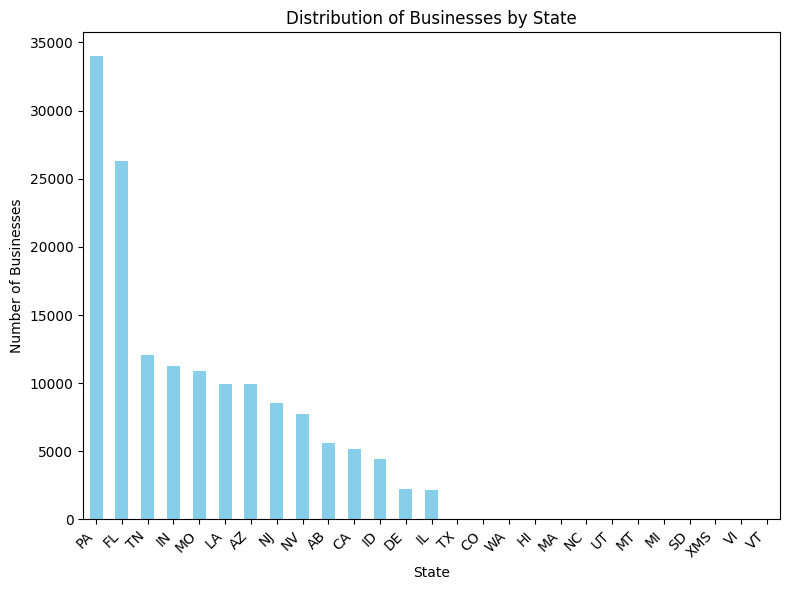

In [15]:
# Connect to SQLite database
conn = sqlite3.connect('yelp_business_data.db')
cursor = conn.cursor()

# Define table names
table_names = ['Address', 'Categories', 'BusinessCategory']

# Load data from each table into DataFrames
dataframes = {}
for table_name in table_names:
  query = f"SELECT * FROM {table_name}"
  dataframes[table_name] = pd.read_sql_query(query, conn)

# Get state counts from the Address DataFrame
state_counts = dataframes['Address']['state'].value_counts()

# Create a bar chart to visualize state distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
state_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Businesses by State')
plt.xlabel('State')
plt.ylabel('Number of Businesses')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()


In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Define table names
table_names = ['Address', 'Categories', 'BusinessCategory']
# ---- Query 3: Distribution of Businesses by State and City ----
# Load data from each table into DataFrames
dataframes = {}
for table_name in table_names:
  query = f"SELECT * FROM {table_name}"
  dataframes[table_name] = pd.read_sql_query(query, conn)


# Get state and city counts
state_city_counts = dataframes['Address'].groupby(['state', 'city'])['business_id'].count()
print(state_city_counts.head())

state  city                   
AB     AB Edmonton                 1
       Alberta Park Industrial     1
       Beaumont                   10
       Downtown                    1
       East Edmonton               1
Name: business_id, dtype: int64


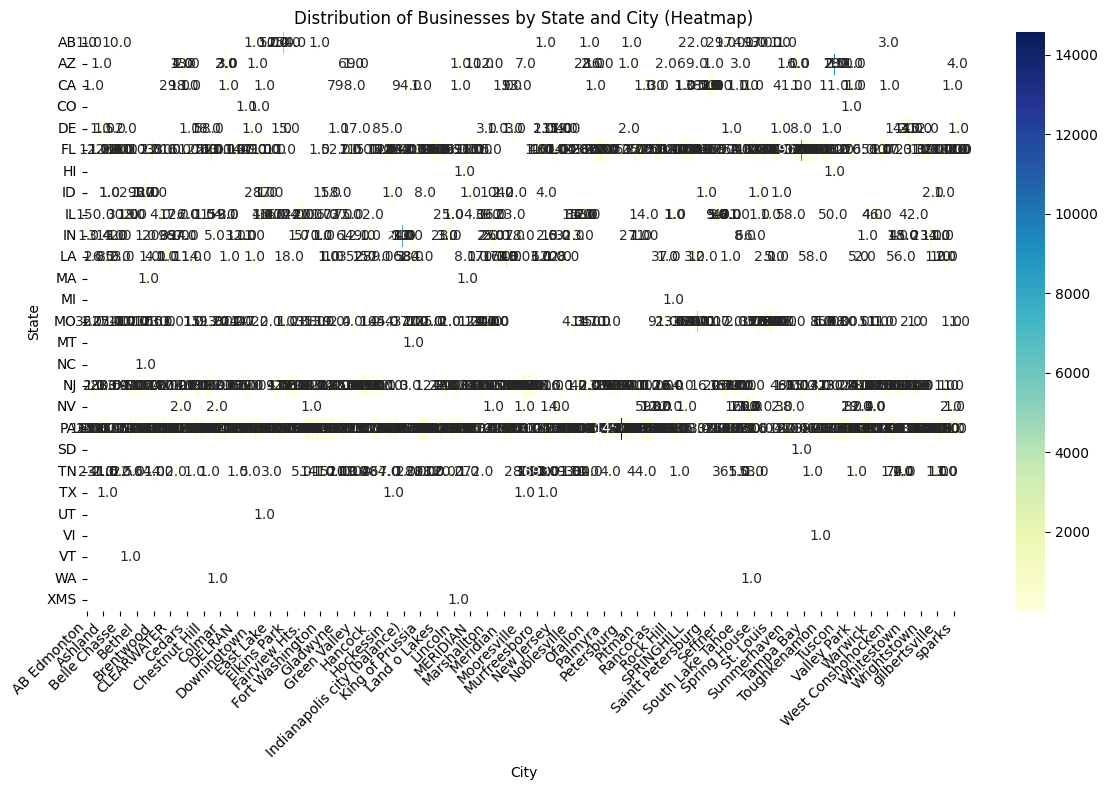

<ipython-input-17-3beea638c0b1>:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

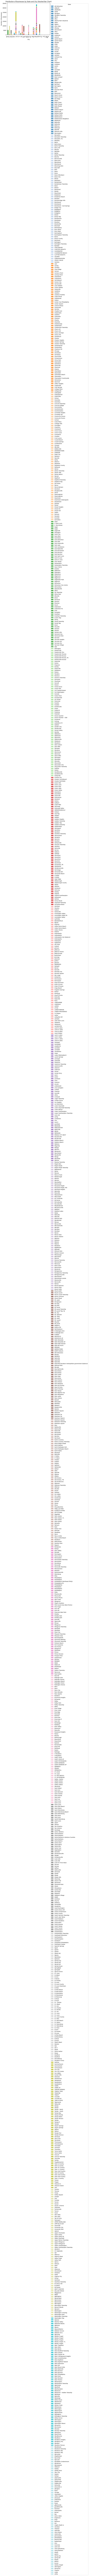

State-city distribution of businesses (example using head):
city   AB Edmonton  AMBLER  ARDMORE  AVON  Abington  Abington Township  \
state                                                                    
AB             1.0     NaN      NaN   NaN       NaN                NaN   
AZ             NaN     NaN      NaN   NaN       NaN                NaN   
CA             NaN     NaN      NaN   NaN       NaN                NaN   
CO             NaN     NaN      NaN   NaN       NaN                NaN   
DE             NaN     NaN      NaN   NaN       NaN                NaN   

city   Affton  Afton  Alberta Park Industrial  Aldan  ...  spring hill  tampa  \
state                                                 ...                       
AB        NaN    NaN                      1.0    NaN  ...          NaN    NaN   
AZ        NaN    NaN                      NaN    NaN  ...          NaN    NaN   
CA        NaN    NaN                      NaN    NaN  ...          NaN    NaN   
CO        NaN   

In [17]:
import seaborn as sns

# ---- Query: Distribution of Businesses by State and City ----

# Get state and city counts
state_city_counts = dataframes['Address'].groupby(['state', 'city'])['business_id'].count().unstack()

# Visualization 1: Heatmap using seaborn
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(state_city_counts, cmap='YlGnBu', annot=True, fmt='.1f')  # Adjust parameters as needed
plt.title('Distribution of Businesses by State and City (Heatmap)')
plt.xlabel('City')
plt.ylabel('State')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

# Visualization 2: Stacked Bar Chart using matplotlib
plt.figure(figsize=(12, 8))
state_city_counts.plot(kind='bar', stacked=True, colormap='tab20')
plt.title('Distribution of Businesses by State and City (Stacked Bar Chart)')
plt.xlabel('City')
plt.ylabel('Number of Businesses')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.legend(title='State', loc='upper left', bbox_to_anchor=(1, 1))  # Adjust legend position
plt.tight_layout()
plt.show()

print("State-city distribution of businesses (example using head):")
print(state_city_counts.head())


In [18]:
import pandas as pd
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect('yelp_business_data.db')

def query_restaurants_by_state():
  # Join tables to get business details with "Restaurants" category
  query = """
    SELECT a.state
    FROM address a
    INNER JOIN businesscategory bc ON a.business_id = bc.business_id
    INNER JOIN categories c ON bc.categories = c.categories
    WHERE c.categories = "Restaurants"
    GROUP BY a.state;
  """
  return pd.read_sql_query(query, conn)

restaurant_states_df = query_restaurants_by_state()
print("States with businesses in the '' category:")
print(restaurant_states_df)

# Close the connection
conn.close()


States with businesses in the '' category:
   state
0     AB
1     AZ
2     CA
3     DE
4     FL
5     ID
6     IL
7     IN
8     LA
9     MO
10    NJ
11    NV
12    PA
13    TN


In [19]:
import pandas as pd
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect('yelp_business_data.db')

def check_empty_tables():
  # Check categories table
  categories_count = pd.read_sql_query("SELECT COUNT(*) FROM categories", conn).iloc[0][0]
  if categories_count == 0:
    print("WARNING: categories table is empty!")

  # Check business_category table
  business_category_count = pd.read_sql_query("SELECT COUNT(*) FROM businesscategory", conn).iloc[0][0]
  if business_category_count == 0:
    print("WARNING: business_category table is empty!")

# Call the check function
check_empty_tables()

# Your other analysis queries here (assuming data is not empty)

# Close the connection
conn.close()


In [20]:
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect('yelp_business_data.db')
cursor = conn.cursor()

# Query for business IDs with stars 4 and above
query = """
SELECT business_id
FROM Reviews
WHERE stars >= 4;
"""

cursor.execute(query)
rows = cursor.fetchall()

# Print business IDs
print("Business IDs with stars 4 and above:")
for row in rows:
  business_id = row[0]  # Assuming the first column (index 0) is business_id
  print(business_id)

# Close connection
conn.close()


Streaming output truncated to the last 5000 lines.
LRr-aw58xVMkUu0OSL_BpQ
Mo8DFMPucDJdbrJTQ1SAIQ
8ipZy-nYcHq7FrQMrxaXWg
4oVEL2nKj3NNr8aMng3nRA
w4nHq_elJwPpI4iZ6ro3JQ
bdoSOSj1LPSAlNoKezVdLQ
r0g6naqWCKdKcTWuYibtNQ
2rlWqmA5tB7nKl_bBXDfLw
vEoIs3OnOiPuhgeMQdjDtw
Mg5Tze0TDgjdh3xcnm9sjQ
-0fOUV_llBAPMo7exZFHPA
9zsurNJH_r-oogHPQK3e9g
GtcRkyNswo0eNRAu68r5Og
mezegXLTf2Vs8kg4gkoM8A
H9T4xn4ie6zC6oRBQ_zhxA
W3TWz-G7KDFqHH23QqCPhw
Cbk40bzKojAjzq01B5FMJQ
irFttJiDNjW-QKbmxNDjUQ
uMKhI_XuLkasrhrS06eMnw
QoezRbYQncpRqyrLH6Iqjg
yr_Ns7yf5CIiWHV9if0IIQ
Ss86BrcEw0ckWT9S1dECNw
qWyd2e8vmXL_mYS7fZUz_g
nN1CR8PdYHFOOQZaR_p6iw
D9nOJiHGnEOSYGNSn2FRNA
vOIGarxPLKIITAi3Kh1j_w
UzquKUxTjBXYSkte30JHgw
UXVjbVfUUjlrZC0IXXiBMw
4IvQU16RBKuLtpgx8yLqmQ
lDKBJjuBhQUZy85t5m0iUg
YU2of3dULVS4Lsp7Q1iouw
krTxH1a9kzWgwvt3PVH8pQ
-9NmUeTphyS9Lq1o9MACGw
CQw-hw0QwaG8pJpIlyi_oA
bjdJ4sTE40Ru06wKQMu24g
MKBrWH1hsgeESjhUaSpVDg
M-6AXSgmDMYcWsF442mzzA
Mz3b0h5BP3rW_2liNJpp2g
8wTLePO7erXmXTFjeSGSOA
AgTMTaQsna5efN9oGKWzrw
qD2fr80U04Fk-Ctx0H_vtg
Eyg_Hs

### **Sentiment Analysis**

In [23]:
import sqlite3

# Sentiment dictionary
sentiment_dict = {
  5: "Very Positive",
  4: "Positive",
  3: "Neutral",
  2: "Negative",
  1: "Very Negative"
}

# Connect to SQLite database
conn = sqlite3.connect('yelp_business_data.db')
cursor = conn.cursor()

# Query for sentiment analysis (excluding rows with NULL stars)
query = """
SELECT business_id, AVG(stars) AS avg_stars, COUNT(*) AS review_count
FROM Reviews
WHERE stars IS NOT NULL  -- Filter out rows with NULL stars
GROUP BY business_id
ORDER BY avg_stars DESC;
"""

cursor.execute(query)
rows = cursor.fetchall()

# Print sentiment analysis
print("Sentiment Analysis of Businesses (Excluding NULL Stars):")
for row in rows:
  business_id = row[0]
  avg_stars = row[1]
  review_count = row[2]

  sentiment = sentiment_dict.get(round(avg_stars))  # Round average stars for clarity

  print(f"Business ID: {business_id}")
  print(f"Average Rating: {avg_stars:.2f} ({sentiment})")  # Format average with 2 decimals
  print(f"Review Count: {review_count}")
  print("---")

# Close connection
conn.close()


Streaming output truncated to the last 5000 lines.
Business ID: cRn_vN7tSIsfYgOIz-K3wg
Average Rating: 1.00 (Very Negative)
Review Count: 1
---
Business ID: cRIS72imKQjmS9JXNU5msQ
Average Rating: 1.00 (Very Negative)
Review Count: 1
---
Business ID: cO7S0V19HO8mQQM8BM-VRQ
Average Rating: 1.00 (Very Negative)
Review Count: 1
---
Business ID: cM62mo1hnlnjNWJ6LQMITQ
Average Rating: 1.00 (Very Negative)
Review Count: 1
---
Business ID: cKkxqm_FzbTYHbYm49hJpQ
Average Rating: 1.00 (Very Negative)
Review Count: 1
---
Business ID: cELvz32yKj-0poQV9K2sOw
Average Rating: 1.00 (Very Negative)
Review Count: 1
---
Business ID: cBZSZpMvjqObmwBD0SfFtQ
Average Rating: 1.00 (Very Negative)
Review Count: 1
---
Business ID: cBO4L7PXJTPSz-8Vcxpo6g
Average Rating: 1.00 (Very Negative)
Review Count: 1
---
Business ID: c8p74KKGR9wAV-rB1N1LiA
Average Rating: 1.00 (Very Negative)
Review Count: 1
---
Business ID: c6xp1swmd-_P87kt3xggDA
Average Rating: 1.00 (Very Negative)
Review Count: 1
---
Business ID: c55Adv

In [27]:
import sqlite3

# Sentiment dictionary
sentiment_dict = {
  5: "Very Positive",
  4: "Positive",
  3: "Neutral",
  2: "Negative",
  1: "Very Negative"
}

# Connect to database
conn = sqlite3.connect('yelp_business_data.db')
cursor = conn.cursor()

# Query for sentiment distribution (excluding NULL stars)
query = """
SELECT
  COALESCE(stars, 0) AS stars,  -- Assign 0 for NULLs with COALESCE
  COUNT(*) AS review_count
FROM Reviews
GROUP BY stars
ORDER BY stars ASC;
"""

cursor.execute(query)
rows = cursor.fetchall()

# Print sentiment distribution
print("Sentiment Distribution of Reviews (Excluding NULL Stars):")
for row in rows:
  stars = row[0]  # Assuming stars is either a valid rating (including 0) or non-NULL
  review_count = row[1]

  sentiment = sentiment_dict.get(stars)
  # Check for empty sentiment category (no reviews for this rating)
  if sentiment is not None:
      print(f"{sentiment}: {review_count} reviews")
  else:
      print(f"No Reviews in this Category: {review_count} (stars: {stars})")

# Close connection
conn.close()


Sentiment Distribution of Reviews (Excluding NULL Stars):
Very Negative: 1986 reviews
No Reviews in this Category: 4932 (stars: 1.5)
Negative: 9527 reviews
No Reviews in this Category: 14316 (stars: 2.5)
Neutral: 18453 reviews
No Reviews in this Category: 26519 (stars: 3.5)
Positive: 31125 reviews
No Reviews in this Category: 27181 (stars: 4.5)
Very Positive: 16307 reviews
